Please upload your train.csv file when prompted...


Saving train.csv to train.csv
Loaded file: train.csv
Dataset shape: (891, 12)

Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Missing values per column:

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Numeric features detected: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical features detected: ['Sex', 'Cabin', 'Embarked']

Top features by absolute association with target (Survived):


,feature,method,value,abs_value
0,Sex,Point-biserial (encoded),0.543351,0.543351
1,Pclass,Pearson,-0.338481,0.338481
2,Cabin,Cramer's V,0.267548,0.267548
3,Fare,Pearson,0.257307,0.257307
4,Embarked,Cramer's V,0.166058,0.166058
5,Parch,Pearson,0.081629,0.081629
6,Age,Pearson,-0.077221,0.077221
7,SibSp,Pearson,-0.035322,0.035322



Top 3 features (ranked):
1. Sex  —  Point-biserial (encoded)  =  0.543351
2. Pclass  —  Pearson  =  -0.338481
3. Cabin  —  Cramer's V  =  0.267548

Full association table saved to 'feature_associations_with_survived.csv'


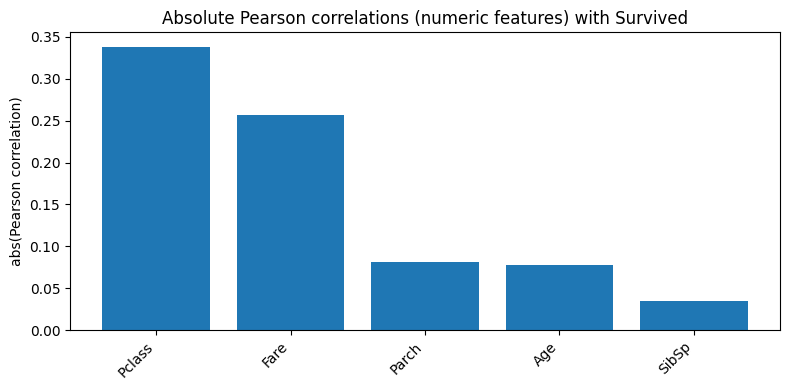

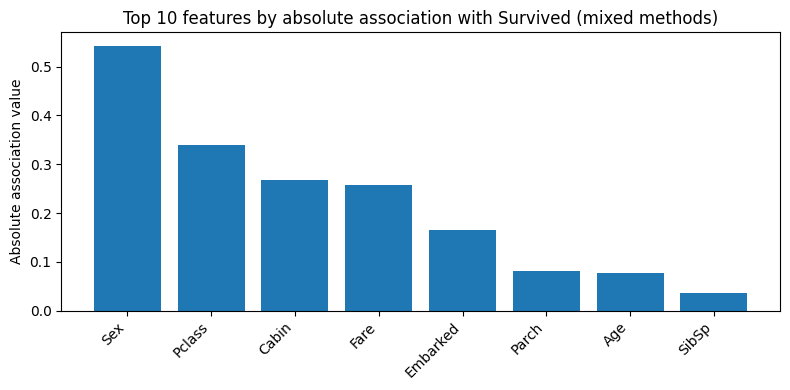


Descriptive statistics (selected):


,mean,median,mode,variance,missing
Survived,0.383838,0.0000,0.00,0.236772,0.0
Pclass,2.308642,3.0000,3.00,0.699015,0.0
Age,29.699118,28.0000,24.00,211.019125,177.0
Fare,32.204208,14.4542,8.05,2469.436846,0.0
SibSp,0.523008,0.0000,0.00,1.216043,0.0
Parch,0.381594,0.0000,0.00,0.649728,0.0



Cabin deck value counts (top):


,count
Cabin_deck,
NaN,687
C,59
B,47
D,33
E,32
A,15
F,13
G,4
T,1



Cramer's V: Cabin_deck vs Survived = 0.1268440882530144
Point-biserial: Cabin_missing vs Survived = -0.3169115231122962

Processed dataset saved to 'titanic_processed_for_analysis.csv'

Analysis complete. Files saved:
 - feature_associations_with_survived.csv
 - titanic_processed_for_analysis.csv


In [1]:
# Full single-file Colab script: Correlation & association analysis for Titanic train.csv
# Paste into one Colab cell and run. Upload train.csv when prompted.

# --- Install & imports -------------------------------------------------------
!pip install --quiet pandas numpy scipy scikit-learn matplotlib

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline

# --- Helper functions -------------------------------------------------------
def cramers_v(x, y):
    """
    Compute Cramer's V statistic for categorical-categorical association.
    Returns float in [0,1].
    """
    df_pair = pd.DataFrame({'x': x, 'y': y}).dropna()
    if df_pair.shape[0] == 0:
        return 0.0
    contingency = pd.crosstab(df_pair['x'], df_pair['y'])
    if contingency.size == 0:
        return 0.0
    chi2, p, dof, expected = chi2_contingency(contingency)
    n = contingency.sum().sum()
    if n == 0:
        return 0.0
    phi2 = chi2 / n
    r, k = contingency.shape
    # bias correction (Bergsma & Wicher)
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    if denom <= 0:
        return 0.0
    return np.sqrt(phi2corr/denom)

# --- Load dataset -----------------------------------------------------------
print("Please upload your train.csv file when prompted...")
uploaded = files.upload()  # interactively choose train.csv
filename = list(uploaded.keys())[0]
print("Loaded file:", filename)
df = pd.read_csv(filename)
print("Dataset shape:", df.shape)
print()

# --- Quick inspection -------------------------------------------------------
print("Columns:", list(df.columns))
print("\nInfo:")
print(df.info())
print("\nMissing values per column:")
print(df.isna().sum())
print("\nFirst 5 rows:")
display(df.head())

# --- Choose target & feature list ------------------------------------------
target = 'Survived'
if target not in df.columns:
    raise ValueError(f"Target column '{target}' not found in dataset. Rename or change target variable.")

exclude = ['PassengerId', 'Name', 'Ticket']  # exclude identifiers/text
features = [c for c in df.columns if c not in exclude and c != target]

numeric_features = df[features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in features if c not in numeric_features]

print("\nNumeric features detected:", numeric_features)
print("Categorical features detected:", categorical_features)
print()

# --- Compute associations ---------------------------------------------------
results = []

# Numeric features -> Pearson correlation
for col in numeric_features:
    ser = df[[col, target]].dropna()
    if ser.shape[0] < 2:
        val = 0.0
    else:
        val = ser[col].corr(ser[target])  # Pearson
    results.append({'feature': col, 'method': 'Pearson', 'value': float(val), 'abs_value': abs(float(val))})

# Categorical features -> point-biserial if binary, else Cramer's V
for col in categorical_features:
    ser = df[[col, target]].dropna()
    if ser.shape[0] == 0:
        val = 0.0
        method = 'Categorical-empty'
    else:
        nunique = ser[col].nunique()
        if nunique == 2:
            codes = pd.factorize(ser[col])[0]
            val = pd.Series(codes).corr(ser[target])
            method = 'Point-biserial (encoded)'
        else:
            val = cramers_v(ser[col], ser[target])
            method = "Cramer's V"
    results.append({'feature': col, 'method': method, 'value': float(val), 'abs_value': abs(float(val))})

res_df = pd.DataFrame(results).sort_values('abs_value', ascending=False).reset_index(drop=True)

# --- Show top associations --------------------------------------------------
print("Top features by absolute association with target (Survived):")
display(res_df.head(15))

# Print top 3 in plain text
top3 = res_df.head(3)
print("\nTop 3 features (ranked):")
for i, row in top3.iterrows():
    print(f"{i+1}. {row['feature']}  —  {row['method']}  =  {row['value']:.6f}")

# Save associations table
res_df.to_csv("feature_associations_with_survived.csv", index=False)
print("\nFull association table saved to 'feature_associations_with_survived.csv'")

# --- Plotting ---------------------------------------------------------------
# Plot numeric Pearson correlations (absolute)
num_corrs = res_df[res_df['method']=='Pearson'].copy()
if not num_corrs.empty:
    num_corrs = num_corrs.set_index('feature').sort_values('abs_value', ascending=False)
    plt.figure(figsize=(8,4))
    plt.bar(num_corrs.index, num_corrs['abs_value'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Absolute Pearson correlations (numeric features) with Survived')
    plt.ylabel('abs(Pearson correlation)')
    plt.tight_layout()
    plt.show()

# Top 10 features overall (mixed methods)
top10 = res_df.head(10).copy()
plt.figure(figsize=(8,4))
plt.bar(top10['feature'], top10['abs_value'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 features by absolute association with Survived (mixed methods)')
plt.ylabel('Absolute association value')
plt.tight_layout()
plt.show()

# --- Descriptive statistics for key columns -------------------------------
cols_for_stats = ['Survived', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch']
descriptives = {}
for c in cols_for_stats:
    if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
        descriptives[c] = {
            'mean': df[c].mean(),
            'median': df[c].median(),
            'mode': df[c].mode().iloc[0] if not df[c].mode().empty else None,
            'variance': df[c].var(),
            'missing': int(df[c].isna().sum())
        }
    else:
        descriptives[c] = {'note': 'non-numeric or absent', 'missing': int(df[c].isna().sum()) if c in df.columns else None}

print("\nDescriptive statistics (selected):")
display(pd.DataFrame(descriptives).T)

# --- Cabin deck extraction & checks ----------------------------------------
if 'Cabin' in df.columns:
    # Extract deck letter (first character); handle NaN
    df['Cabin_deck'] = df['Cabin'].astype(str).str[0].replace({'n': np.nan})
    df['Cabin_missing'] = df['Cabin'].isna().astype(int)
    print("\nCabin deck value counts (top):")
    display(df['Cabin_deck'].value_counts(dropna=False).head(15))
    print("\nCramer's V: Cabin_deck vs Survived =", cramers_v(df['Cabin_deck'], df['Survived']))
    print("Point-biserial: Cabin_missing vs Survived =", pd.Series(df['Cabin_missing']).corr(df['Survived']))
else:
    print("\nNo Cabin column available in dataset.")

# --- Save processed file for later modeling --------------------------------
df.to_csv("titanic_processed_for_analysis.csv", index=False)
print("\nProcessed dataset saved to 'titanic_processed_for_analysis.csv'")

# --- End -------------------------------------------------------------------
print("\nAnalysis complete. Files saved:\n - feature_associations_with_survived.csv\n - titanic_processed_for_analysis.csv")
